In [1]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

In [2]:
os.makedirs("../input/segmentation", exist_ok=True)
os.makedirs("../input/segmentation/test", exist_ok=True)
os.makedirs("../input/segmentation/train", exist_ok=True)
os.makedirs("../input/segmentation/train/augmentation", exist_ok=True)
os.makedirs("../input/segmentation/train/image", exist_ok=True)
os.makedirs("../input/segmentation/train/mask", exist_ok=True)
os.makedirs("../input/segmentation/train/dilate", exist_ok=True)

In [3]:
INPUT_DIR = os.path.join("..", "input")

SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation") # lung_unet\input\segmentation
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test") # lung_unet\input\segmentation\test
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train") # lung_unet\input\segmentation\train
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation") # lung_unet\input\segmentation\train\augmentation
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")  # lung_unet\input\segmentation\train\image
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask") # lung_unet\input\segmentation\train\mask
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate") # lung_unet\input\segmentation\train\dilate
SEGMENTATION_SOURCE_DIR = os.path.join(INPUT_DIR, \
                                       "pulmonary-chest-xray-abnormalities")  # lung_unet\input\pulmonary-chest-xray-abnormalities

SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "ChinaSet_AllFiles", \
                                  "ChinaSet_AllFiles")  # lung_unet\input\pulmonary-chest-xray-abnormalities\ChinaSet_AllFiles\ChinaSet_AllFiles
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png") # lung_unet\input\pulmonary-chest-xray-abnormalities\ChinaSet_AllFiles\ChinaSet_AllFiles\CXR_png
SHENZHEN_MASK_DIR = os.path.join(INPUT_DIR, "shcxr-lung-mask", "mask", "mask") # lung_unet\input\shcxr-lung-mask\mask\mask

MONTGOMERY_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, \
                                    "Montgomery", "MontgomerySet") # lung_unet\input\pulmonary-chest-xray-abnormalities\Montgomery\MontgomerySet
MONTGOMERY_IMAGE_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "CXR_png") # lung_unet\input\pulmonary-chest-xray-abnormalities\Montgomery\MontgomerySet\CXR_png
MONTGOMERY_LEFT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                        "ManualMask", "leftMask") # lung_unet\input\pulmonary-chest-xray-abnormalities\Montgomery\MontgomerySet\ManualMask\leftMask
MONTGOMERY_RIGHT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                         "ManualMask", "rightMask")

DILATE_KERNEL = np.ones((15, 15), np.uint8)

BATCH_SIZE=2

#Prod
EPOCHS=56

#Desv
#EPOCHS=16

In [4]:
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))   # lung_unet\input\pulmonary-chest-xray-abnormalities\Montgomery\MontgomerySet\ManualMask\leftMask
montgomery_test = montgomery_left_mask_dir[0:50]
montgomery_train= montgomery_left_mask_dir[50:]

for left_image_file in tqdm(montgomery_left_mask_dir):
    base_file = os.path.basename(left_image_file) # extract the image name from left to get the same mask name in right
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file) # lung_unet\input\pulmonary-chest-xray-abnormalities\Montgomery\MontgomerySet\CXR_png
    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)

    image = cv2.imread(image_file)
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    
    image = cv2.resize(image, (512, 512))
    left_mask = cv2.resize(left_mask, (512, 512))
    right_mask = cv2.resize(right_mask, (512, 512))
    
    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (left_image_file in montgomery_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image) # lung_unet\input\segmentation\train\image
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask) # lung_unet\input\segmentation\train\mask
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate) # lung_unet\input\segmentation\train\dilate
    else:
        filename, fileext = os.path.splitext(base_file)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)  # lung_unet\input\segmentation\test
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

  0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 138/138 [00:35<00:00,  3.91it/s]


In [5]:
print(f'base_file path:', base_file)
print(f'image_file path:', image_file)
im = cv2.imread(image_file)
l_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
print(f'image size:', im.shape)
print(f'mask size:', l_mask.shape)
print(f'mask dilation size:', mask_dilate.shape)
print(f'filename: {filename}, fileext: {fileext}')


base_file path: MCUCXR_0399_1.png
image_file path: ..\input\pulmonary-chest-xray-abnormalities\Montgomery\MontgomerySet\CXR_png\MCUCXR_0399_1.png
image size: (4892, 4020, 3)
mask size: (4892, 4020)
mask dilation size: (512, 512)
filename: MCUCXR_0064_0, fileext: .png


In [6]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]
    
    # mask_coord[0], mask_coord[1] are row and column coordinates of all non black pixels

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret # comnine image, mask and dilate

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

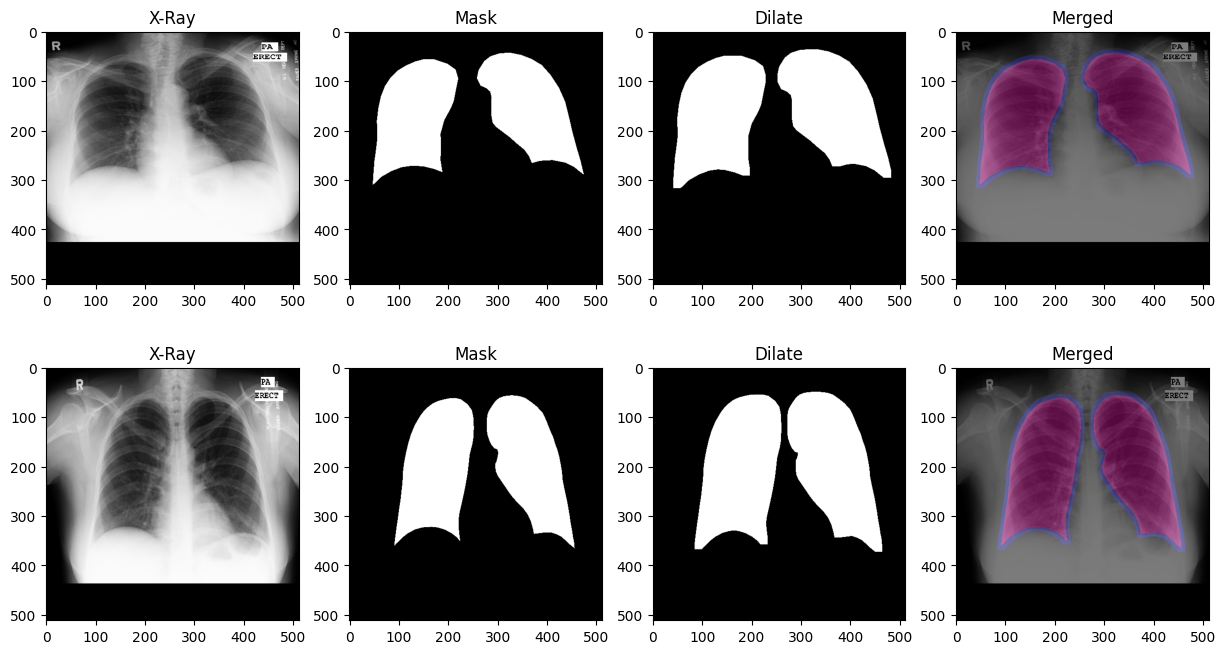

In [7]:
base_file = os.path.basename(montgomery_train[0])

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(montgomery_test[0])
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [8]:
# shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.png')) # lung_unet\input\shcxr-lung-mask\mask\mask
# shenzhen_test = shenzhen_mask_dir[0:50]
# shenzhen_train= shenzhen_mask_dir[50:]

# for mask_file in tqdm(shenzhen_mask_dir):
#     base_file = os.path.basename(mask_file).replace("_mask", "")
#     image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)   # lung_unet\input\pulmonary-chest-xray-abnormalities\ChinaSet_AllFiles\ChinaSet_AllFiles\CXR_png

#     image = cv2.imread(image_file)
#     mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        
#     image = cv2.resize(image, (512, 512))
#     mask = cv2.resize(mask, (512, 512))
#     mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
#     if (mask_file in shenzhen_train):
#         cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
#                     image)  # lung_unet\input\segmentation\train\image
#         cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
#                     mask)
#         cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
#                     mask_dilate)
#     else:
#         filename, fileext = os.path.splitext(base_file)

#         cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
#                     image)
#         cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
#                                  "%s_mask%s" % (filename, fileext)), mask)
#         cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
#                                  "%s_dilate%s" % (filename, fileext)), mask_dilate)

In [9]:
# base_file = os.path.basename(shenzhen_train[0].replace("_mask", ""))

# image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
# mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
# dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

# image = cv2.imread(image_file)
# mask_image = cv2.imread(mask_image_file)
# dilate_image = cv2.imread(dilate_image_file)
# merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
# fig, axs = plt.subplots(2, 4, figsize=(15, 8))

# axs[0, 0].set_title("X-Ray")
# axs[0, 0].imshow(image)

# axs[0, 1].set_title("Mask")
# axs[0, 1].imshow(mask_image)

# axs[0, 2].set_title("Dilate")
# axs[0, 2].imshow(dilate_image)

# axs[0, 3].set_title("Merged")
# axs[0, 3].imshow(merged_image)

# base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))
# image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
# filename, fileext = os.path.splitext(base_file)
# mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
#                                "%s_mask%s" % (filename, fileext))

# filename, fileext = os.path.splitext(base_file)
# image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
# mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
#                                "%s_mask%s" % (filename, fileext))
# dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
#                                  "%s_dilate%s" % (filename, fileext))

# image = cv2.imread(image_file)
# mask_image = cv2.imread(mask_image_file)
# dilate_image = cv2.imread(dilate_image_file)
# merged_image = add_colored_dilate(image, mask_image, dilate_image)

# axs[1, 0].set_title("X-Ray")
# axs[1, 0].imshow(image)

# axs[1, 1].set_title("Mask")
# axs[1, 1].imshow(mask_image)

# axs[1, 2].set_title("Dilate")
# axs[1, 2].imshow(dilate_image)

# axs[1, 3].set_title("Merged")
# axs[1, 3].imshow(merged_image)

In [10]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(88, 200, 88, 88)

In [11]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory( # load image and mask in a given path
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator) # match each pair
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask): # normalize pixel value to [0, 1], apply the threshold
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1 # white
    mask[mask <= 0.5] = 0 # black
    
    return (img, mask)

In [12]:
# From: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred): # measure two samples' similarity
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred) # loss

def unet(input_size=(256,256,1)): # single channel for gray image
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [13]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img  # (1, 256, 256, 1) for keras 

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [14]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(512, 512)))

len(test_files), len(validation_data)

(50, 2)

In [15]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'dilate', 
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))

model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

model_checkpoint = ModelCheckpoint('unet_lung_seg.hdf5', 
                                   monitor='loss', 
                                   verbose=1, 
                                   save_best_only=True)

history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE, 
                              epochs=EPOCHS, 
                              callbacks=[model_checkpoint],
                              validation_data = validation_data)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

C:\Users\z004vp1t\AppData\Local\Temp\ipykernel_10252\665482282.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/56
44/44 [==============================] - ETA: 0s - loss: -0.3893 - dice_coef: 0.3893 - binary_accuracy: 0.4538
Epoch 1: loss improved from inf to -0.38926, saving model to unet_lung_seg.hdf5


c:\Users\z004vp1t\AppData\Local\miniconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 193s 4s/step - loss: -0.3893 - dice_coef: 0.3893 - binary_accuracy: 0.4538 - val_loss: -0.3724 - val_dice_coef: 0.3724 - val_binary_accuracy: 0.3261
Epoch 2/56
44/44 [==============================] - ETA: 0s - loss: -0.3893 - dice_coef: 0.3893 - binary_accuracy: 0.3730
Epoch 2: loss improved from -0.38926 to -0.38932, saving model to unet_lung_seg.hdf5
44/44 [==============================] - 199s 5s/step - loss: -0.3893 - dice_coef: 0.3893 - binary_accuracy: 0.3730 - val_loss: -0.3732 - val_dice_coef: 0.3732 - val_binary_accuracy: 0.4117
Epoch 3/56
44/44 [==============================] - ETA: 0s - loss: -0.3912 - dice_coef: 0.3912 - binary_accuracy: 0.4598
Epoch 3: loss improved from -0.38932 to -0.39121, saving model to unet_lung_seg.hdf5
44/44 [==============================] - 210s 5s/step - loss: -0.3912 - dice_coef: 0.3912 - binary_accuracy: 0.4598 - val_loss: -0.3739 - val_dice_coef: 0.3739 - val_binary_accuracy: 0.4628
Epoch 4/56
44/44

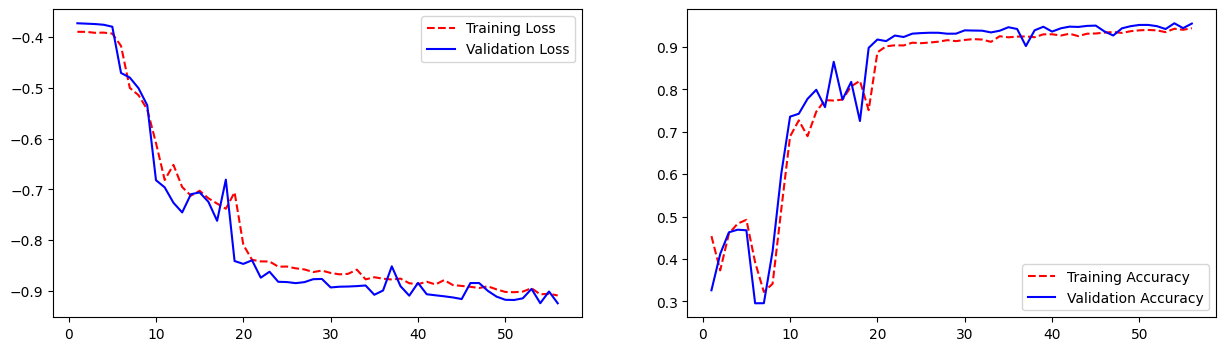

In [19]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

In [20]:
test_gen = test_generator(test_files, target_size=(512,512))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(SEGMENTATION_TEST_DIR, results, test_files)

C:\Users\z004vp1t\AppData\Local\Temp\ipykernel_10252\655890498.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = model.predict_generator(test_gen, len(test_files), verbose=1)


50/50 [==============================] - 19s 384ms/step


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


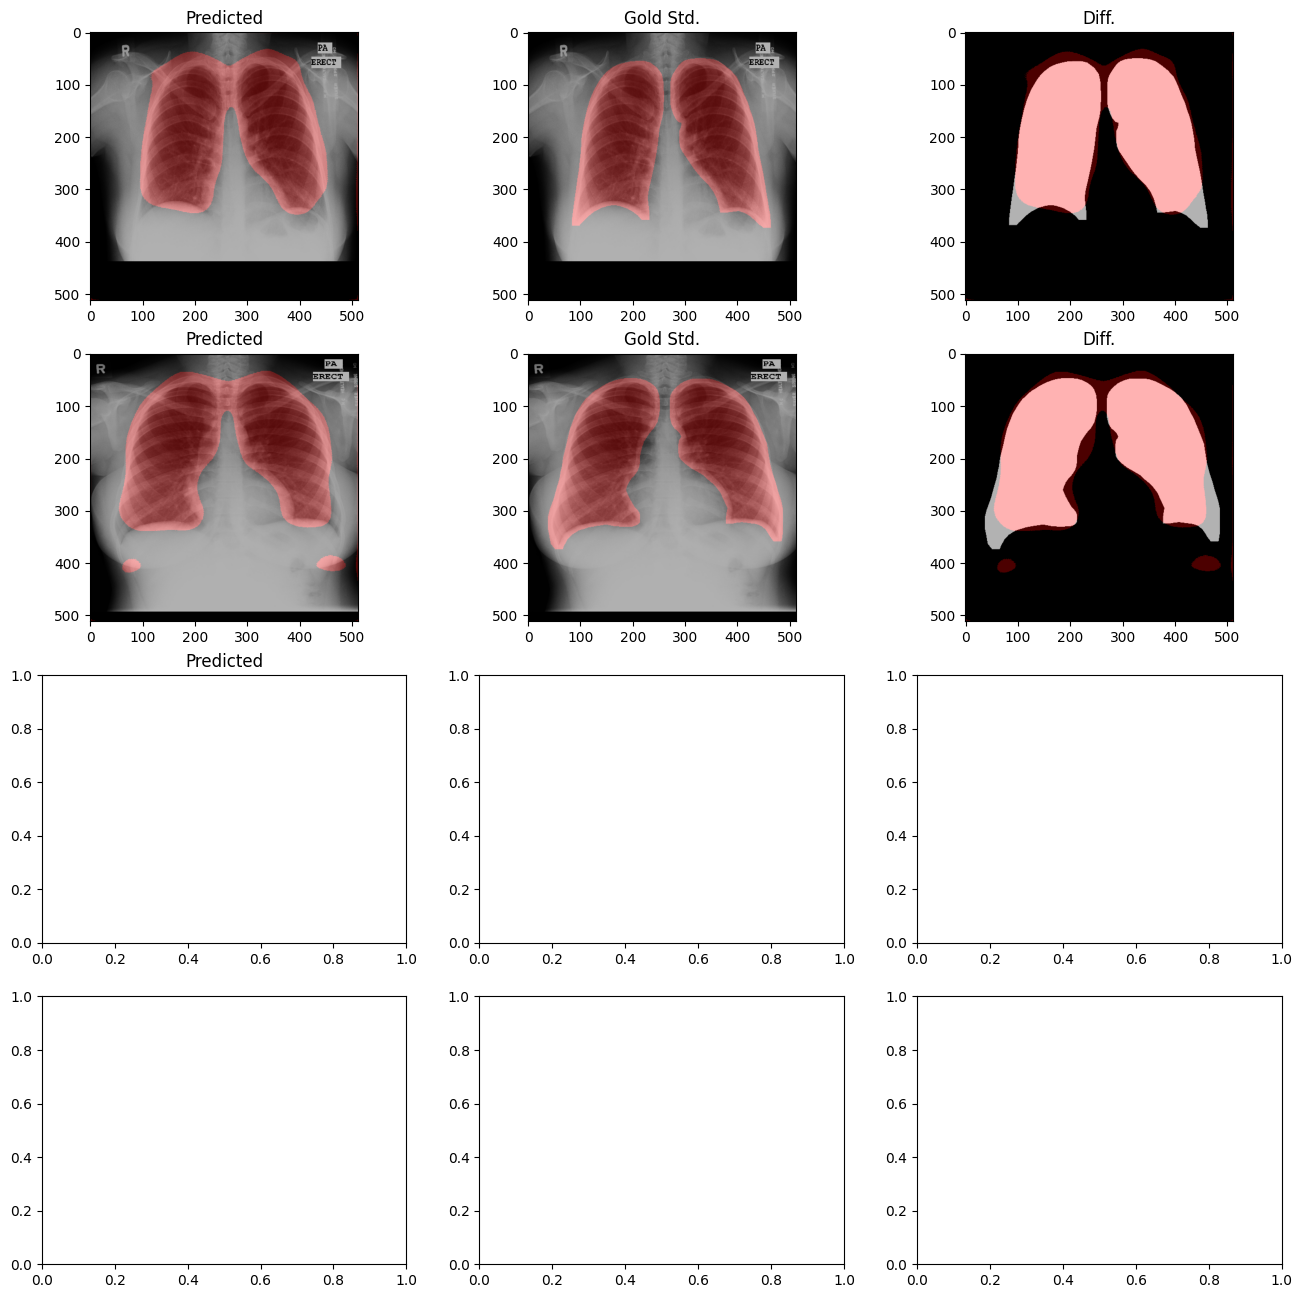

In [21]:
image = cv2.imread("../input/segmentation/test/MCUCXR_0001_0.png")
predict_image = cv2.imread("../input/segmentation/test/MCUCXR_0001_0_predict.png")
mask_image = cv2.imread("../input/segmentation/test/MCUCXR_0001_0_dilate.png")

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("../input/segmentation/test/MCUCXR_0003_0.png")
predict_image = cv2.imread("../input/segmentation/test/MCUCXR_0003_0_predict.png")
mask_image = cv2.imread("../input/segmentation/test/MCUCXR_0003_0_dilate.png")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("../input/segmentation/test/CHNCXR_0004_0.png")
predict_image = cv2.imread("../input/segmentation/test/CHNCXR_0004_0_predict.png")
mask_image = cv2.imread("../input/segmentation/test/CHNCXR_0004_0_dilate.png")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("../input/segmentation/test/MCUCXR_0016_0.png")
predict_image = cv2.imread("../input/segmentation/test/MCUCXR_0016_0_predict.png")
mask_image = cv2.imread("../input/segmentation/test/MCUCXR_0016_0_dilate.png")

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))